In [1]:
import pandas as pd
import numpy as np
import io
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
path_training = 'gender_images/Training/'
path_validation = 'gender_images/Validation/'

In [3]:
# import keras 
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# image_size = (90, 90)
# batch_size = 64

# target_size = (224, 224)
# input_shape=(224, 224, 3)
# min_lr = 0.0001
# steps_per_epoch=256
# validation_steps=256
# epochs=8


# train_datagen = ImageDataGenerator(rescale = 1./255,
#       rotation_range=25,
#       width_shift_range=0.2,
#       height_shift_range=0.2,
#       shear_range=0.2,
#       zoom_range=0.2,
#       horizontal_flip=True,
#       fill_mode='nearest')

# test_datagen = ImageDataGenerator( rescale = 1.0/255)

# train_generator = train_datagen.flow_from_directory(
#     path_training,
#     seed=10,
#     target_size=(224,224),
#     batch_size=batch_size,
#     classes=['female','male'],
#     shuffle=True,
# )

# validation_generator = test_datagen.flow_from_directory(
#     path_validation,
#     seed=10,
#     target_size=(224,224),
#     batch_size=batch_size,
#     classes=['female','male'],
#     shuffle=True
# )

In [4]:
image_size = (224, 224)
batch_size = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(path_training,
                                                               seed=1993, 
                                                               image_size = image_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(path_validation,
                                                             seed=1993,
                                                             image_size = image_size)

one_hot_encoded_train_ds = train_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))
one_hot_encoded_val_ds = val_ds.map(lambda x, y: (x, tf.one_hot(y, depth=3)))

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

Found 47009 files belonging to 2 classes.
Found 11649 files belonging to 2 classes.


In [5]:
vgg_model = keras.applications.VGG16(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False)
vgg_model.trainable = False


inputs = keras.Input(shape=(224, 224, 3))
x = vgg_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
epochs=20
model.compile(optimizer=keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 14,715,201
Trainable params: 513
Non-trainable params: 14,714,688
_________________________________________________________________


In [6]:
vgg16_fit = model.fit(one_hot_encoded_train_ds, 
                      epochs=epochs, 
                      validation_data=one_hot_encoded_val_ds)

Epoch 1/20
1470/1470 [==============================] - 78s 50ms/step - loss: 7.1730 - accuracy: 0.4850 - val_loss: 5.7947 - val_accuracy: 0.5761
Epoch 2/20
1470/1470 [==============================] - 74s 50ms/step - loss: 5.4448 - accuracy: 0.6151 - val_loss: 5.1409 - val_accuracy: 0.6533
Epoch 3/20
1470/1470 [==============================] - 74s 51ms/step - loss: 5.2606 - accuracy: 0.6341 - val_loss: 5.2086 - val_accuracy: 0.6427
Epoch 4/20
1470/1470 [==============================] - 73s 50ms/step - loss: 5.1860 - accuracy: 0.6458 - val_loss: 5.1426 - val_accuracy: 0.6625
Epoch 5/20
1470/1470 [==============================] - 74s 51ms/step - loss: 5.1318 - accuracy: 0.6635 - val_loss: 5.1443 - val_accuracy: 0.6629
Epoch 6/20
1470/1470 [==============================] - 73s 50ms/step - loss: 5.1335 - accuracy: 0.6633 - val_loss: 5.1363 - val_accuracy: 0.6652
Epoch 7/20
1470/1470 [==============================] - 73s 50ms/step - loss: 5.1365 - accuracy: 0.6655 - val_loss: 5.1363 -

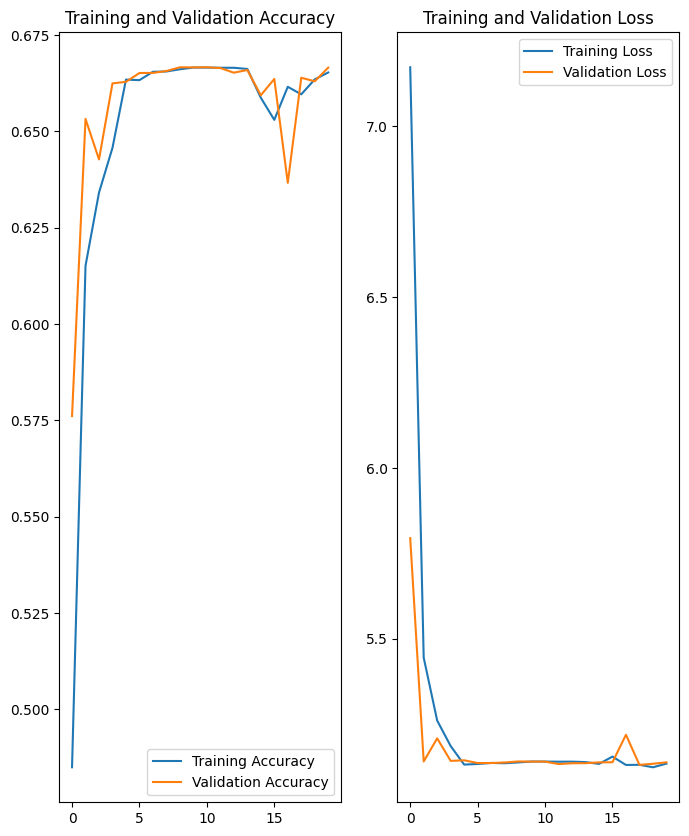

In [7]:
acc= vgg16_fit.history['accuracy']
val_acc = vgg16_fit.history['val_accuracy']

loss = vgg16_fit.history['loss']
val_loss = vgg16_fit.history['val_loss']

import matplotlib.pyplot as plt

epochs_range = range(epochs)

plt.figure(figsize=(8, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()